<a href="https://colab.research.google.com/github/Julian27R/Analitica_de_Datos/blob/main/Proyecto_Final_AnaliticaD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
#**Sistema de Clasificación de Fallos en Vehículos de Nueva Energía mediante Aprendizaje Automático**

###**Por:**
*   **Julián Felipe Gutiérrez Ramírez**
*   **Felipe Idárraga Quintero**

**Fecha de presentación 21/07/2025**



---

#1. Cargar Base de datos




In [ ]:
#cargar datos desde drive acceso libre
#https://drive.google.com/file/d/1zT3nKbhRi0trJ8UgdKu7SOFYV3izSC2P/view?usp=sharing
FILEID = "1zT3nKbhRi0trJ8UgdKu7SOFYV3izSC2P"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

--2025-07-21 15:03:29--  https://docs.google.com/uc?export=download&confirm=&id=1zT3nKbhRi0trJ8UgdKu7SOFYV3izSC2P
Resolving docs.google.com (docs.google.com)... 173.194.203.113, 173.194.203.139, 173.194.203.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.203.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1zT3nKbhRi0trJ8UgdKu7SOFYV3izSC2P&export=download [following]
--2025-07-21 15:03:29--  https://drive.usercontent.google.com/download?id=1zT3nKbhRi0trJ8UgdKu7SOFYV3izSC2P&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.98.132, 2607:f8b0:400e:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.98.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 730354 (713K) [application/octet-stream]
Saving to: ‘codigos.zip’

codigos.zip         100%[===================>] 713.24K  --.-

#2. Lectura de la base de datos con Pandas

In [ ]:
import numpy as np #importar librerias básicas
import os

# fijar semilla para fines pedagógicos
np.random.seed(42)

#render de figs sobre notebook
%matplotlib inline
# para graficar
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#crear carpeta con resultados
import os
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

import warnings #eliminar warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [ ]:
import pandas as pd #importar pandas
NEV_fault_dataset = pd.read_csv('NEV_fault_dataset.csv')#leer archivo csv con pandas
NEV_fault_dataset.head() #encabezado principal

Fault Label            Voltage (V)             Current (A)  \
0          0.0  9.389.222.561.858.270  19.953.520.847.257.500   
1          0.0  9.543.699.325.140.040  12.117.506.772.672.700   
2          0.0  8.104.640.450.186.150     382.501.409.468.062   
3          0.0  9.665.762.073.479.400  24.026.179.474.791.700   
4          0.0  8.382.145.574.284.380   3.078.129.493.167.370   

       Motor Speed (RPM)        Temperature (°C)           Vibration (g)  \
0  5.444.030.305.614.170  23.950.804.238.730.900   3.012.837.712.138.580   
1  9.627.712.888.003.810   3.779.416.084.171.510   7.061.867.140.317.350   
2  5.572.228.902.612.280   4.869.387.373.245.660   7.883.388.406.870.150   
3  9.065.794.097.478.730   4.047.195.354.547.190   1.551.860.959.418.050   
4  2.354.583.171.880.980   4.261.761.062.128.550  28.754.710.399.280.800   

       Ambient Temp (°C)            Humidity (%)  
0  5.824.351.728.359.610   3.973.396.531.120.100  
1  7.767.233.474.874.770   5.025.524.977.931.410  
2  3.263.498.763.039.200  16.849.267.652.363.600  
3    780.072.077.989.834   7.041.054.130.991.420  
4  9.240.887.255.059.420   6.262.884.930.517.110

# 3. Identificar tipos de variables, campos perdidos y preproceso básico a realizar

In [ ]:
NEV_fault_dataset.info() #revisar cantidad de datos, tipos de datos, campos vacios

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Fault Label        11000 non-null  float64
 1   Voltage (V)        11000 non-null  object 
 2   Current (A)        11000 non-null  object 
 3   Motor Speed (RPM)  11000 non-null  object 
 4   Temperature (°C)   11000 non-null  object 
 5   Vibration (g)      11000 non-null  object 
 6   Ambient Temp (°C)  11000 non-null  object 
 7   Humidity (%)       11000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 687.6+ KB


## Se presentan atributos tipo int, float y texto.

#4. Se realiza la partición de Datos de entrenamiento y de testeo; de entrenamiento va a corresponder el 70% y de testeo el 30%.

In [ ]:
#librerias para proceso
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
# Partición entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%

Xtrain, Xtest = train_test_split(NEV_fault_dataset,test_size=0.3)
col_sal = "Fault Label"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)

#5. Preproceso: completar datos y codificar datos tipo texto

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")#se utiliza estimador de moda
ytrain = imputer.fit_transform(pd.DataFrame(ytrain)).reshape(-1)#ajuste sobre la salida
ytest = imputer.transform(pd.DataFrame(ytest)).reshape(-1)#evaluar sobre datos de test

print(ytrain.shape, ytest.shape)

(7700,) (3300,)


In [ ]:
ytrain[0]

np.float64(2.0)

## Se define la clase personalizada compatible con Scikit-Learn

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
import re

class CustomDecimalCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, target_col='Fault Label'):
        self.target_col = target_col
        self.columns_to_clean = None

    def fit(self, X, y=None):
        # Identificar columnas tipo object, excepto el target
        self.columns_to_clean = X.select_dtypes(include='object').columns.difference([self.target_col]).tolist()
        return self

    def transform(self, X):
        df = X.copy()

        for col in self.columns_to_clean:
            df[col] = (
                df[col]
                .astype(str)
                .str.replace('.', '', regex=False)           # quitar todos los puntos
                .str.extract(r'(\d{6})')                      # extraer los primeros 6 dígitos
                .astype(float)
                .div(1_000_000)                               # convertir a decimal: 0.xxxxxx
            )

        # Asegurar que la columna target sea tipo float (sin modificarla)
        if self.target_col in df.columns:
            df[self.target_col] = df[self.target_col].astype(float)

        return df

#Crear el Encoder
cleaner = CustomDecimalCleaner()

#Ajustar y transfmormar
Xtrain_clean = cleaner.fit_transform(Xtrain)
Xtest_clean = cleaner.transform(Xtest)
Xtrain_clean['Fault Label'] = ytrain
Xtest_clean['Fault Label'] = ytest

In [ ]:
Xtrain.head()

Voltage (V)             Current (A)       Motor Speed (RPM)  \
8957    6.399.430.470.405.350   2.660.051.282.565.780   2.112.747.523.172.700   
1507      838.724.309.396.762     828.882.044.170.718   8.186.884.525.656.630   
6383      882.562.482.071.976   6.370.224.314.178.330  23.035.232.536.572.600   
1559    7.800.995.408.232.940  14.644.051.787.162.400   4.434.182.760.795.630   
10017  10.374.171.563.838.700  42.243.776.401.871.500  35.255.016.283.946.100   

             Temperature (°C)           Vibration (g)       Ambient Temp (°C)  \
8957    7.003.378.600.672.900  19.201.747.527.727.400  47.504.497.048.089.900   
1507    5.505.614.045.735.680  27.395.852.259.792.600   7.373.575.985.029.780   
6383   42.580.515.678.470.200   9.580.398.294.066.960   2.113.654.350.001.640   
1559   15.120.536.175.138.900  14.287.449.045.304.600   7.271.813.766.389.310   
10017   7.853.913.007.095.200  12.721.401.216.899.200   5.323.329.312.699.020   

                Humidity (%)  
8957   6.915.436.663.073.850  
1507     771.168.309.309.204  
6383   7.219.803.416.087.410  
1559   6.477.797.567.062.180  
10017  9.654.128.082.662.920

In [ ]:
Xtrain_clean.head()

Voltage (V)  Current (A)  Motor Speed (RPM)  Temperature (°C)  \
8957      0.639943     0.266005           0.211274          0.700337   
1507      0.838724     0.828882           0.818688          0.550561   
6383      0.882562     0.637022           0.230352          0.425805   
1559      0.780099     0.146440           0.443418          0.151205   
10017     0.103741     0.422437           0.352550          0.785391   

       Vibration (g)  Ambient Temp (°C)  Humidity (%)  Fault Label  
8957        0.192017           0.475044      0.691543          2.0  
1507        0.273958           0.737357      0.771168          0.0  
6383        0.958039           0.211365      0.721980          1.0  
1559        0.142874           0.727181      0.647779          0.0  
10017       0.127214           0.532332      0.965412          3.0

In [ ]:
Xtrain_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7700 entries, 8957 to 7270
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Voltage (V)        7699 non-null   float64
 1   Current (A)        7699 non-null   float64
 2   Motor Speed (RPM)  7698 non-null   float64
 3   Temperature (°C)   7699 non-null   float64
 4   Vibration (g)      7698 non-null   float64
 5   Ambient Temp (°C)  7696 non-null   float64
 6   Humidity (%)       7695 non-null   float64
 7   Fault Label        7700 non-null   float64
dtypes: float64(8)
memory usage: 541.4 KB


In [ ]:
Xtrain_clean.isnull().sum()

Voltage (V)          1
Current (A)          1
Motor Speed (RPM)    2
Temperature (°C)     1
Vibration (g)        2
Ambient Temp (°C)    4
Humidity (%)         5
Fault Label          0
dtype: int64

##Al verificar que despues de transformar las variables de tipo objeto a tipo flotantes, se generaron valores faltantes, para esto se inputan los datos faltantes usando la Mediana

In [ ]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Imputar en Xtrain_clean
imputer = SimpleImputer(strategy='median')
Xtrain_imputed = pd.DataFrame(imputer.fit_transform(Xtrain_clean), columns=Xtrain_clean.columns)
Xtest_imputed = pd.DataFrame(imputer.transform(Xtest_clean), columns=Xtest_clean.columns)

In [ ]:
Xtrain_imputed.head()

Voltage (V)  Current (A)  Motor Speed (RPM)  Temperature (°C)  \
0     0.639943     0.266005           0.211274          0.700337   
1     0.838724     0.828882           0.818688          0.550561   
2     0.882562     0.637022           0.230352          0.425805   
3     0.780099     0.146440           0.443418          0.151205   
4     0.103741     0.422437           0.352550          0.785391   

   Vibration (g)  Ambient Temp (°C)  Humidity (%)  Fault Label  
0       0.192017           0.475044      0.691543          2.0  
1       0.273958           0.737357      0.771168          0.0  
2       0.958039           0.211365      0.721980          1.0  
3       0.142874           0.727181      0.647779          0.0  
4       0.127214           0.532332      0.965412          3.0

In [ ]:
Xtrain_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Voltage (V)        7700 non-null   float64
 1   Current (A)        7700 non-null   float64
 2   Motor Speed (RPM)  7700 non-null   float64
 3   Temperature (°C)   7700 non-null   float64
 4   Vibration (g)      7700 non-null   float64
 5   Ambient Temp (°C)  7700 non-null   float64
 6   Humidity (%)       7700 non-null   float64
 7   Fault Label        7700 non-null   float64
dtypes: float64(8)
memory usage: 481.4 KB


In [ ]:
Xtrain_imputed.isnull().sum()

Voltage (V)          0
Current (A)          0
Motor Speed (RPM)    0
Temperature (°C)     0
Vibration (g)        0
Ambient Temp (°C)    0
Humidity (%)         0
Fault Label          0
dtype: int64

#6. Se realiza análisis exploratorio básico

##**Se aplica normalización Standscaler para la normalización de las todas las variables incluyendo la variable objetivo Fault Label**

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Separar características (sin Fault Label)
Xtrain_features = Xtrain_imputed.drop(columns='Fault Label')
Xtest_features = Xtest_imputed.drop(columns='Fault Label')

# Escalador
scaler = StandardScaler()

# Ajustar con Xtrain y transformar ambos
Xtrain_scaled = scaler.fit_transform(Xtrain_features)
Xtest_scaled = scaler.transform(Xtest_features)

# Reconstruir los DataFrames escalados con las mismas columnas + 'Fault Label'
Xtrain_scaled_df = pd.DataFrame(Xtrain_scaled, columns=Xtrain_features.columns)
Xtrain_scaled_df['Fault Label'] = Xtrain_imputed['Fault Label'].reset_index(drop=True)

Xtest_scaled_df = pd.DataFrame(Xtest_scaled, columns=Xtest_features.columns)
Xtest_scaled_df['Fault Label'] = Xtest_imputed['Fault Label'].reset_index(drop=True)

In [ ]:
Xtrain_scaled_df.head()

Voltage (V)  Current (A)  Motor Speed (RPM)  Temperature (°C)  \
0    -0.487218    -0.810292          -1.119195          1.173292   
1     0.484981     1.560974           1.333322          0.493610   
2     0.699384     0.752714          -1.042165         -0.072532   
3     0.198258    -1.313991          -0.181882         -1.318664   
4    -3.109675    -0.151282          -0.548774          1.559266   

   Vibration (g)  Ambient Temp (°C)  Humidity (%)  Fault Label  
0      -0.799683          -0.244753      0.543614          2.0  
1      -0.475303           0.765889      0.850341          0.0  
2       2.232768          -1.260658      0.660862          1.0  
3      -0.994226           0.726683      0.375028          0.0  
4      -1.056219          -0.024033      1.598600          3.0

In [ ]:
Xtest_scaled_df.head()

Voltage (V)  Current (A)  Motor Speed (RPM)  Temperature (°C)  \
0     0.533400     2.200197           0.173208         -1.332178   
1     0.243610    -0.189466          -0.957302         -0.260640   
2     0.309225    -0.595256          -1.140526         -1.248683   
3     0.130011     0.927884          -0.804138          0.058067   
4     0.197186     0.771292          -0.895591         -1.359047   

   Vibration (g)  Ambient Temp (°C)  Humidity (%)  Fault Label  
0      -1.015927           1.057939     -0.883649          0.0  
1       1.482428           0.857894     -0.228216          1.0  
2       0.660697           0.001873     -0.090478          1.0  
3      -1.155428           0.646560      1.712762          0.0  
4       1.220239          -0.145532      0.370848          0.0

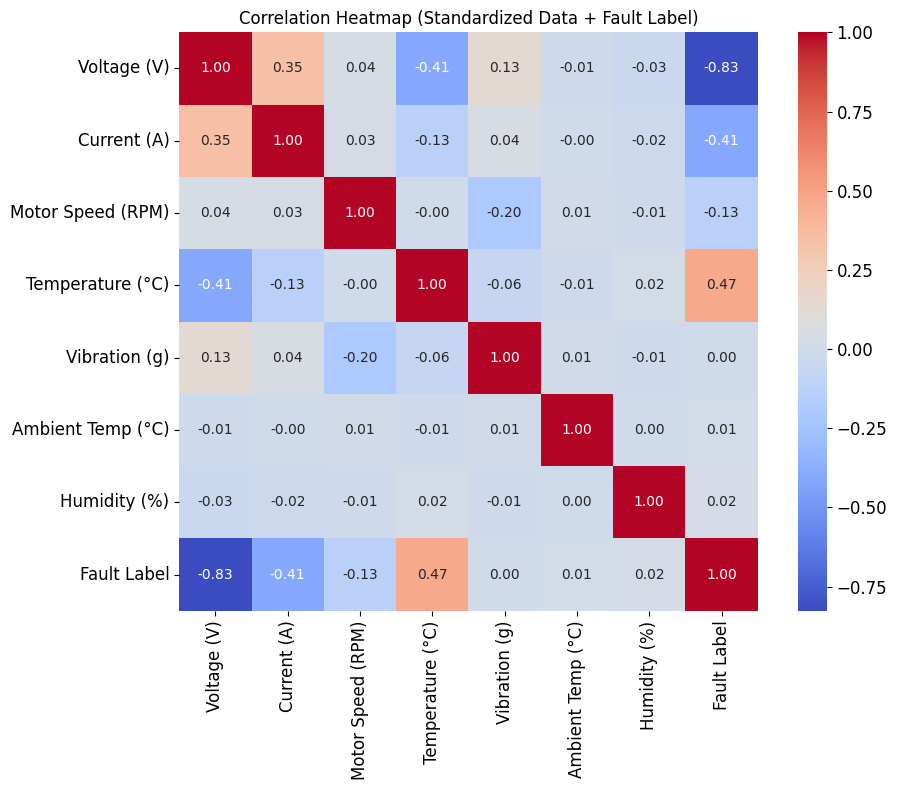

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que todas las columnas sean numéricas (ya lo son en este caso)
numeric_df = Xtrain_scaled_df.select_dtypes(include=['float64', 'int64'])

# Calcular matriz de correlación
correlation_matrix = numeric_df.corr()

# Graficar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap (Standardized Data + Fault Label)')
plt.tight_layout()
plt.show()


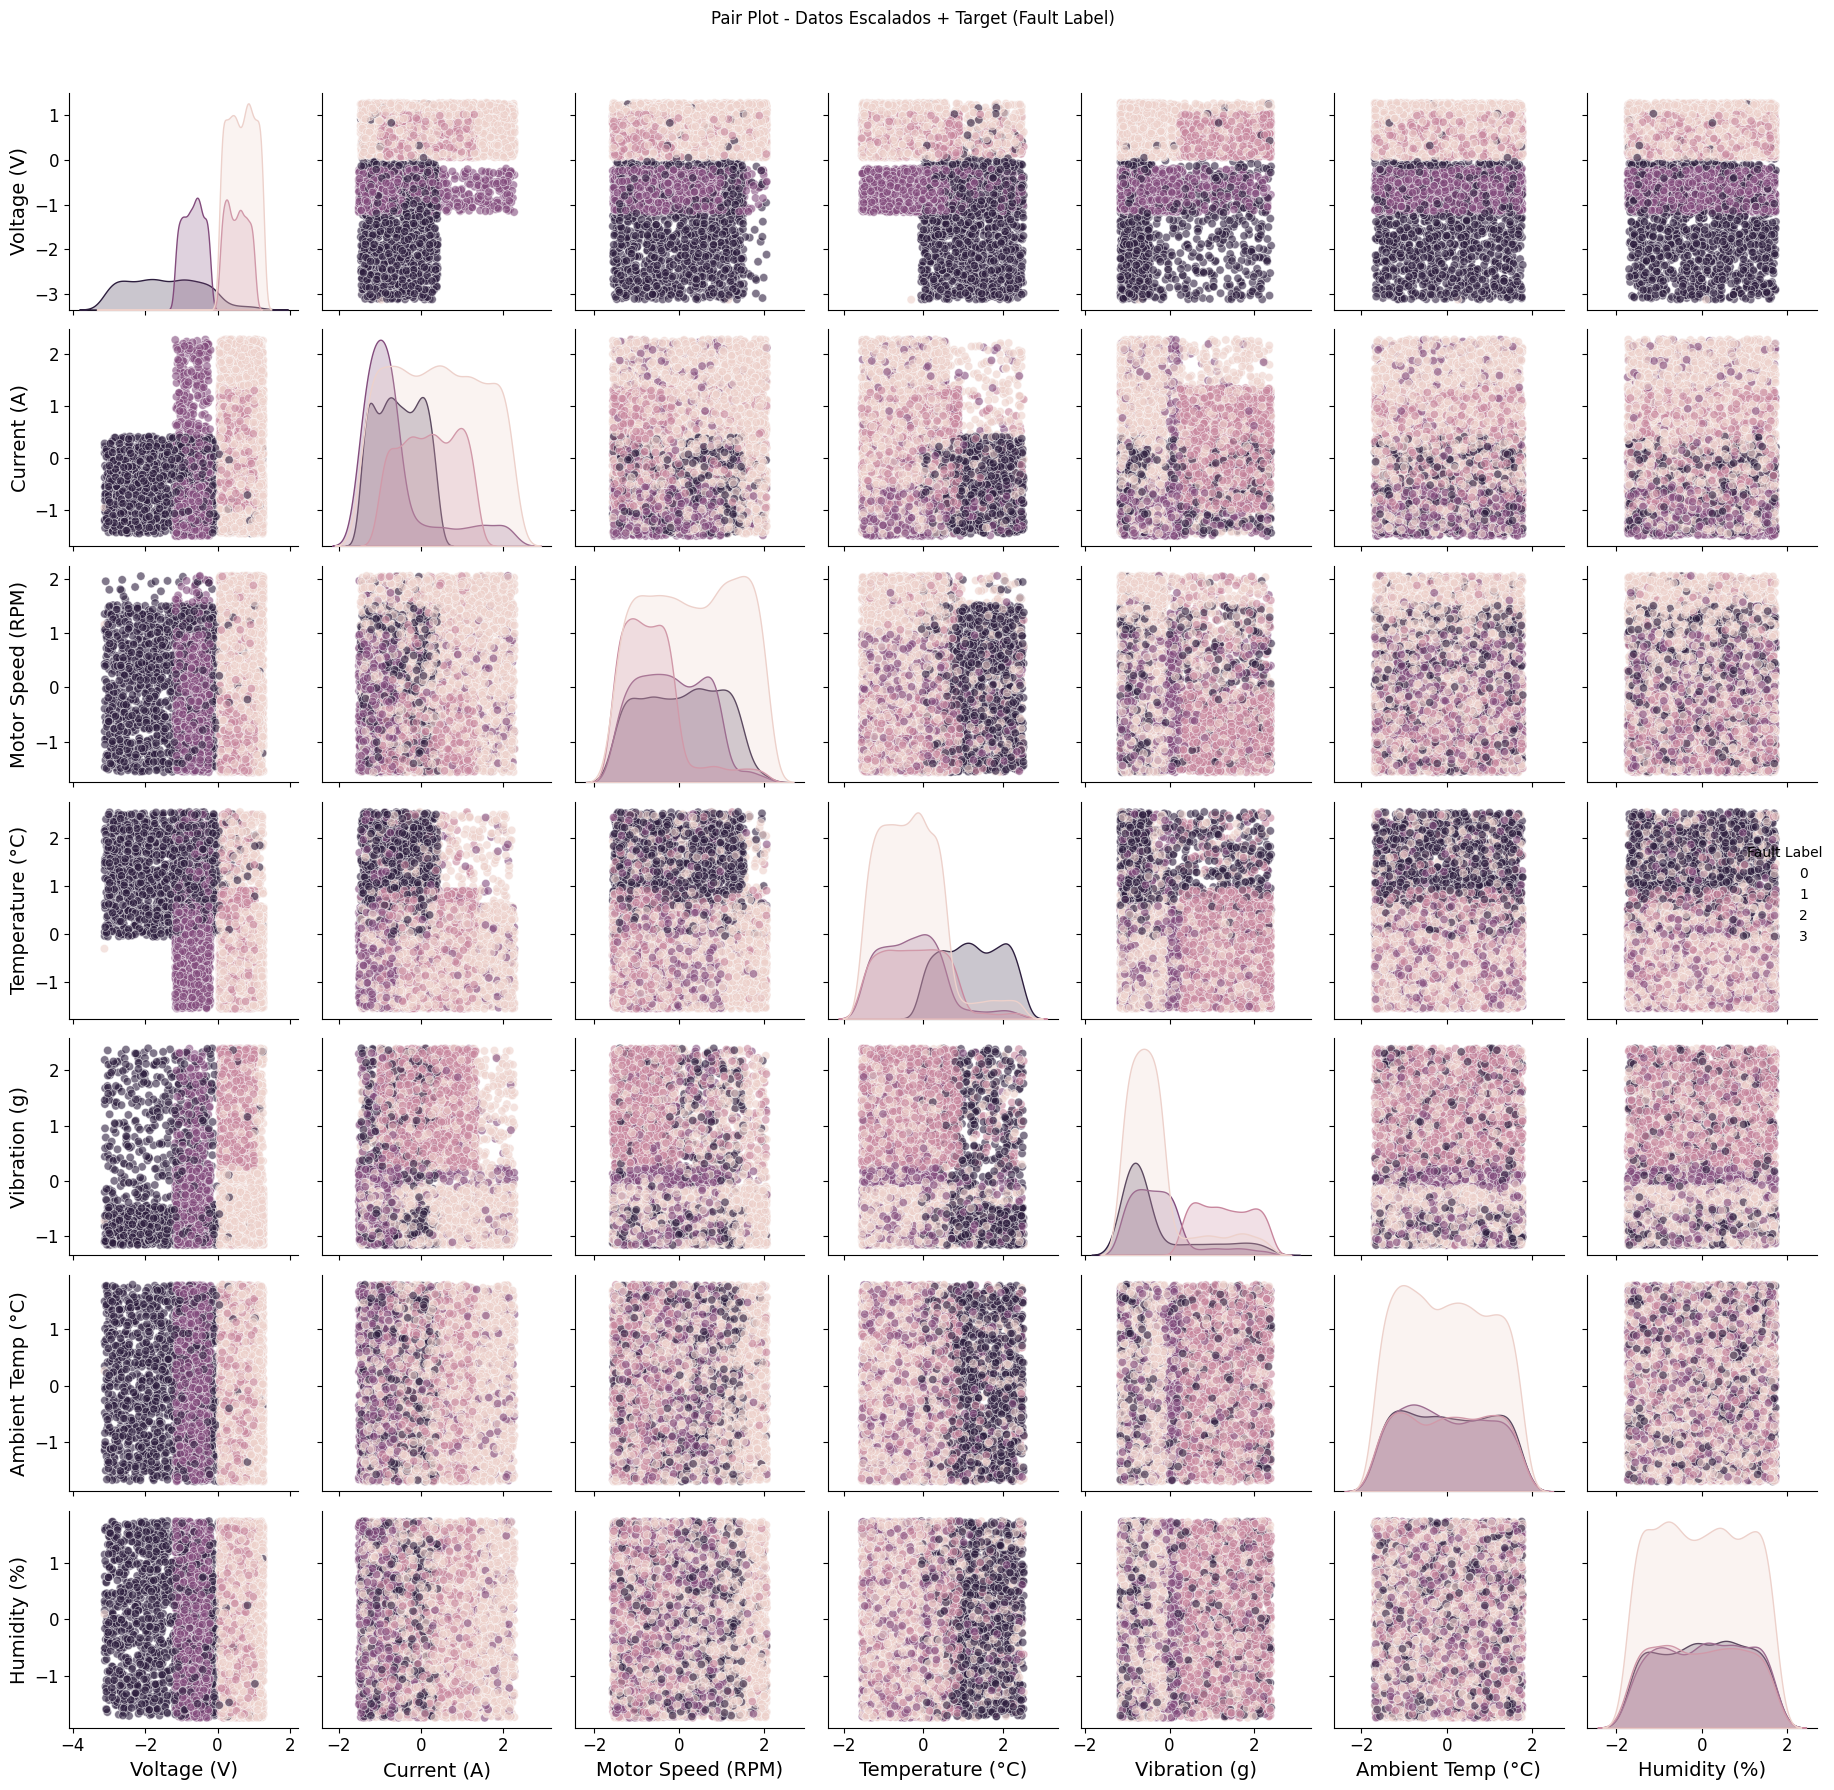

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Copiar y asegurarse que el target esté como entero
df_pairplot = Xtrain_scaled_df.copy()
df_pairplot['Fault Label'] = df_pairplot['Fault Label'].astype(int)

# Generar pairplot
sns.pairplot(df_pairplot, hue='Fault Label', diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle("Pair Plot - Datos Escalados + Target (Fault Label)", y=1.02)
plt.tight_layout()
plt.show()


#**Construcción del Modelo**
Se va a construir un Clasificador de Bosque Aleatorio para predecir la etiqueta de falla con base en las lecturas del sensor. El Bosque Aleatorio es un método de conjunto robusto que suele tener un buen rendimiento en tareas de clasificación.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 1. Separar características (X) y etiquetas (y)
X_train = Xtrain_scaled_df.drop(columns='Fault Label')
y_train = Xtrain_scaled_df['Fault Label'].astype(int)

X_test = Xtest_scaled_df.drop(columns='Fault Label')
y_test = Xtest_scaled_df['Fault Label'].astype(int)

# 2. Inicializar y entrenar el clasificador Random Forest
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',  # útil si hay desbalance
    random_state=42
)

rf_classifier.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

#**Evaluación del modelo**

Accuracy: 0.9306

Classification report:
              precision    recall  f1-score   support

           0     0.9436    0.9543    0.9489      1509
           1     0.8896    0.8954    0.8925       612
           2     0.9500    0.9245    0.9371       596
           3     0.9204    0.9125    0.9165       583

    accuracy                         0.9306      3300
   macro avg     0.9259    0.9217    0.9237      3300
weighted avg     0.9307    0.9306    0.9306      3300


Confusion Matrix:
[[1440   68    0    1]
 [  64  548    0    0]
 [   0    0  551   45]
 [  22    0   29  532]]


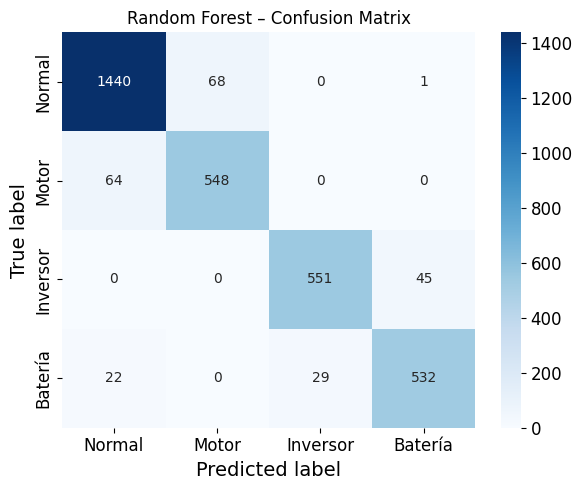

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Predicciones ===
y_pred = rf_classifier.predict(X_test)

# === 2. Accuracy ===
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# === 3. Reporte de clasificación ===
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# === 4. Matriz de confusión (números) ===
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# === 5. Heatmap de la matriz de confusión ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Normal', 'Motor', 'Inversor', 'Batería'],
            yticklabels=['Normal', 'Motor', 'Inversor', 'Batería'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest – Confusion Matrix')
plt.tight_layout()
plt.show()


#**App Web con Streamlit**

###1. Instala dependencias en Colab

In [ ]:
!pip install -q streamlit scikit-learn pandas joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
import joblib
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ('scaler', scaler),          # tu StandardScaler entrenado
    ('model',  rf_classifier)    # el RandomForest entrenado
])
joblib.dump(full_pipeline, 'fault_pipeline.pkl')

['fault_pipeline.pkl']

###2. Exporta el modelo/pipeline

In [ ]:
# ╔═╡ Colab cell 2
import joblib, pathlib

pathlib.Path('model').mkdir(exist_ok=True)
joblib.dump(full_pipeline, 'model/fault_pipeline.pkl')      # ⬅️ usa tu variable real
print('✅  Modelo guardado en model/fault_pipeline.pkl')


✅  Modelo guardado en model/fault_pipeline.pkl


###3. Crea app.py

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
from pathlib import Path

# ── Conversor: 9.389  ➜  "938900" ➜ 0.9389 ──────────────────────────────
def dec3_to_model_units(x: float) -> float:
    """
    Convierte un número con 3 decimales (ej. 9.389) al formato
    de 6 dígitos que usó el modelo (0.9389).
    """
    s = f"{x:.3f}".replace('.', '')   # quita el punto -> "9389"
    s = (s + '000000')[:6]            # rellena/corta hasta 6 dígitos
    return int(s) / 1_000_000         # 938900 -> 0.9389


# --- Cargar pipeline ---
pipeline = joblib.load(Path(__file__).parent / 'model' / 'fault_pipeline.pkl')

st.title("🛠️ Predicción de Fallos en Transmisión EV")

inputs = {
    'Voltage (V)'      : st.number_input("Voltage (V)",      0.0, 1000.0, 0.0, step=0.001),
    'Current (A)'      : st.number_input("Current (A)",      0.0, 500.0, 0.0, step=0.001),
    'Motor Speed (RPM)': st.number_input("Motor Speed",      0.0, 20000.0, 0.0, step=0.001),
    'Temperature (°C)' : st.number_input("Temperature (°C)", -40.0, 150.0, 0.0, step=0.001),
    'Vibration (g)'    : st.number_input("Vibration (g)",    0.0, 50.0, 0.0, step=0.001),
    'Ambient Temp (°C)': st.number_input("Ambient Temp (°C)",-40.0, 70.0, 0.0, step=0.001),
    'Humidity (%)'     : st.number_input("Humidity (%)",     0.0, 100.0, 0.0, step=0.001)
}

if st.button("🔍 Predecir"):
    X_user = pd.DataFrame([{k: dec3_to_model_units(v) for k, v in inputs.items()}])

    pred   = pipeline.predict(X_user)[0]

    proba  = pipeline.predict_proba(X_user)[0]

    clases = {0:'Normal',1:'Falla Motor',2:'Falla Inversor',3:'Falla Batería'}
    st.success(f"Resultado: **{clases[pred]}**")

    st.subheader("Probabilidades")
    st.bar_chart(pd.Series(proba, index=clases.values()))


Overwriting app.py


###4. Crea requirements.txt

In [ ]:
%%writefile requirements.txt
streamlit>=1.28
scikit-learn>=1.3
pandas>=2.0
joblib>=1.3


Overwriting requirements.txt


###5. Prueba rápida en Colab (opcional)

In [ ]:
!pip install streamlit pyngrok

In [ ]:
# ╔═╡ Colab cell 5  ✅

from pyngrok import ngrok, conf
conf.get_default().region = "us"        # o "sa"
conf.get_default().auth_token = "2xbQ2LIhhqTUCyRMtyHaqy9cZym_inbfFpBVWsG79Gzdy7EA"  # ← añade tu token

public_url = ngrok.connect(8501)
print("⚡ URL pública:", public_url)

# Lanza Streamlit en segundo plano
!streamlit run app.py --server.headless=true --server.port=8501 & sleep 5


⚡ URL pública: NgrokTunnel: "https://aab6c7106631.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.197.126.131:8501

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomFo